# LOAD FORECASTING TUTORIAL - Exploratory Data Analysis

### This notebook was created by Miha Grabner and is part of the [blog series about Load Forecasting](https://www.mihagrabner.com/post/load-forecasting-tutorial-part-2-exploratory-data-analysis).
#### If you want to see more, please visit [mihagrabner.com](https://www.mihagrabner.com/) or a LinkedIn group [AI in Smart Grids](https://www.linkedin.com/groups/13621702/).
#### If you like my work please share it with others!

# LIBS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = "w"

import warnings
warnings.filterwarnings('ignore')

# HELPER FUNCTIONS

In [2]:
def get_season(ts_in):
    season = pd.Series()

    for year in ts_in.index.year.unique():

        # CREATE SEASONS
        yearly_season = pd.Series("inter-season", index=ts_in.loc[str(year)].index)

        yearly_season.loc[: "{}-2-15".format(year)] = "winter"
        yearly_season.loc["{}-11-15".format(year) :] = "winter"
        yearly_season.loc["{}-5-15".format(year) : "{}-9-15".format(year)] = "summer"

        season = pd.concat([season, yearly_season])
    return season


def plotly_df(df_in, slider=False):
    """
    plots all cols of time series df
    """
    if isinstance(df_in, pd.Series):
        df = df_in.to_frame()
    else: 
        df = df_in.copy()

    title = "TS Data"

    def tuple2rgb(color_palette): return ["rgb" + str(color) for color in color_palette]
    color_list = tuple2rgb(sns.color_palette(n_colors=df.shape[1]))

    plot_data = []

    for i, col in enumerate(df.columns):

        go_scatter = go.Scatter(x=df.index,
                                y=df.loc[:, col],
                                line=go.scatter.Line(color=color_list[i], width=2),
                                opacity=0.8,
                                name=col,
                                text="")
        plot_data.append(go_scatter)

    layout = go.Layout(height=800, width=900, 
                       font=dict(size=18),
                       title=title,
                       xaxis=dict(title='Timestamps',  # xlabel
                                            # Range selector with buttons
                                             rangeselector=dict(
                                                 # Buttons for selecting time scale
                                                 buttons=list([
                                                     # 1 day
                                                     dict(count=1,
                                                          label='1d',
                                                          step='day',
                                                          stepmode='todate'),
                                                     # 1 week
                                                     dict(count=7,
                                                          label='1w',
                                                          step='day',
                                                          stepmode='todate'),
                                                     # 1 month
                                                     dict(count=1,
                                                          label='1m',
                                                          step='month',
                                                          stepmode='backward'), 
                                                     # Entire scale
                                                     dict(step='all')
                                                 ])
                                             ),
                                             # Sliding for selecting time window
                                             rangeslider=dict(visible=True),
                                             # Type of xaxis
                                             type='date'),
                       # yaxis is unchanged
                       yaxis=dict(title='')  # ylabel
                       )
    if not slider: layout = None
    fig = go.Figure(data=plot_data, layout=layout)
    fig.show()
    

def plot_mean_daily_profiles(ts, season_str):
    x_axis = pd.date_range("2017-1-1", periods=24, freq="1h").strftime("%H:%M")
    fontsize = 15
    
    df = ts[season == season_str].to_frame()
    df = df.assign(weekday_name = df.index.weekday_name,
                   hour = df.index.strftime("%H:%M"))
    weekday_names = ["Monday", "Tuesday", "Wendesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    (df.pivot_table("load", index="weekday_name", columns="hour")
       .T
       .loc[:, weekday_names]
       .plot(figsize=[8, 5],
             lw=3));
    
    plt.xticks(np.arange(0, len(x_axis), 2), x_axis[::2]);
    plt.xlabel("Hour", fontsize=fontsize)
    plt.ylabel("Load [MW]", fontsize=fontsize);
    plt.grid()
    plt.title("Mean Daily Profile - {}".format(season_str), fontsize=fontsize+5);
    plt.ylim(10, 23)
    
    
def plot_scatter(x, y, xlabel, ylabel, title, freq, s=30):
    df = pd.concat([x, y], axis=1)
    
    seasons = ["winter", "inter-season", "summer"]
    colors = {"winter": blue, "inter-season": grey, "summer": red}    

    fig = plt.figure(figsize=[17, 5])
    size = 15
    alpha=0.5

    for i, season_str in enumerate(seasons):

        fig.add_subplot(1, 3, i+1)
        df[season==season_str].resample(freq).mean().plot.scatter(ax=plt.gca(),
                        x=x.name,
                        y=y.name,
                        s=s, 
                        alpha=alpha,
                        color=colors[season_str]
                       );
        plt.grid()
        plt.xlabel(xlabel, size=size)
        plt.ylabel(ylabel, size=size)
        plt.title("{} - {}".format(season_str.capitalize(), title), size=size);
        plt.xticks(size=size, rotation=45), plt.yticks(size=size);

# IMPORT DATA

In [3]:
# INPUT DATA
ts = (pd.read_csv("load.csv", index_col=["timestamp"], parse_dates=True)
        .iloc[:, 0].rename("load"))

temp = (pd.read_csv("temperature.csv", index_col=["timestamp"], parse_dates=True)
          .iloc[:, 0].rename("temp"))

# OTHER


blue = sns.color_palette("muted", desat=0.9)[0]
green = sns.color_palette("muted", desat=0.9)[2]
red = sns.color_palette("muted", desat=0.9)[3]
grey = sns.color_palette("muted", desat=0.9)[7]

season = get_season(ts).rename("season")

ts.head(2)

timestamp
2013-01-01 00:00:00    16.4
2013-01-01 01:00:00    16.1
Name: load, dtype: float64

# PLOT 1: JUST DO IT!

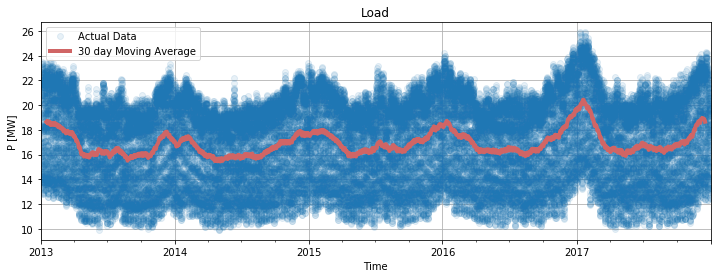

In [4]:
ts.plot(figsize=[12, 4], alpha=0.1, marker="o", linestyle="");
ts.rolling(window=30*24, center=True).mean().plot(ax=plt.gca(), color=red, lw=4);
plt.legend(["Actual Data", "30 day Moving Average"])
plt.grid()
plt.xticks(), plt.yticks();
plt.xlabel("Time"), plt.ylabel("P [MW]");
plt.title("Load");

# PLOT NO. 2: DIVE IN!

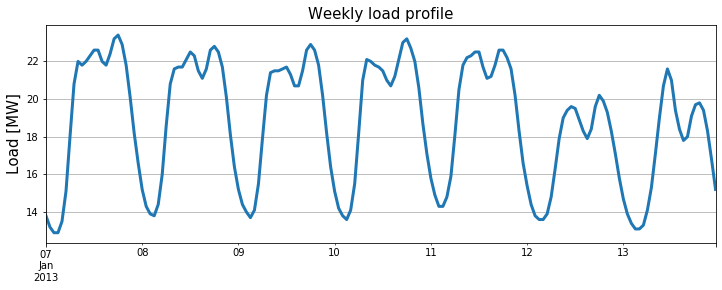

In [5]:
ts["2013-1-7": "2013-1-13"].plot(figsize=[12, 4], lw=3);
plt.ylabel("Load [MW]", fontsize=15)
plt.title("Weekly load profile", fontsize=15)
plt.xlabel("")
plt.grid()

In [6]:
plotly_df(ts)

# PLOT NO. 3: IT'S ALL ABOUT DAILY PROFILES!

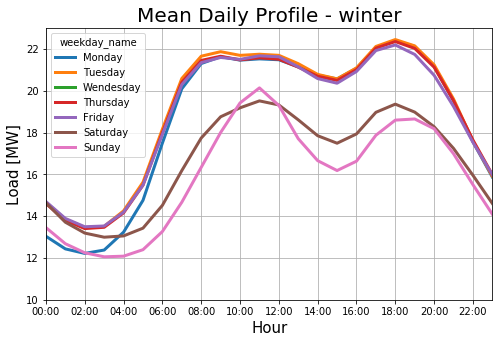

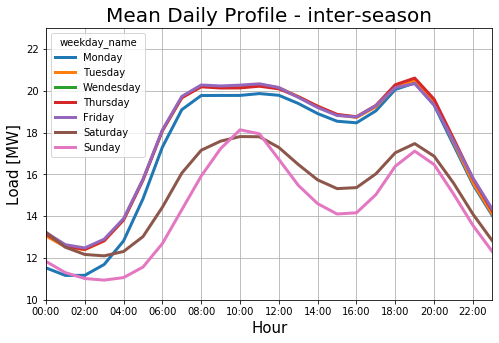

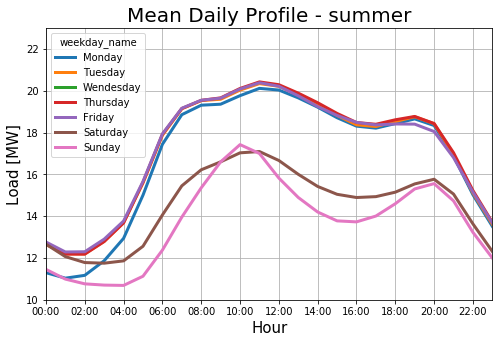

In [7]:
plot_mean_daily_profiles(ts, season_str="winter")
plot_mean_daily_profiles(ts, season_str="inter-season")
plot_mean_daily_profiles(ts, season_str="summer")

# PLOT NO. 4: LOAD VS. TEMPERATURE

## 4.1 Weekly Peak Load and Weekly Mean Temperature

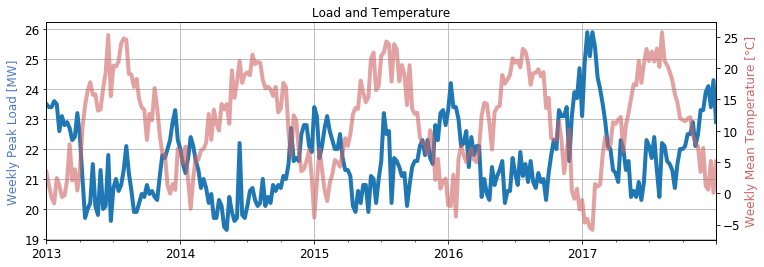

In [8]:
fig, ax1 = plt.subplots(figsize=[12, 4])

ts.resample("W").max().plot(ax=ax1, lw=4)
plt.xlabel("")
plt.ylabel("Weekly Peak Load [MW]", fontsize=12, color=blue);
plt.xticks(fontsize=12), plt.yticks(fontsize=12);
plt.grid()
plt.title("Load and Temperature")

ax2 = ax1.twinx()
temp.resample("W").mean().plot(ax=ax2, alpha=0.6, lw=4,
          color=red);
plt.yticks(fontsize=12);
plt.ylabel("Weekly Mean Temperature [°C]", fontsize=12, color=red);

## 4.2 Load & temperature Correlation

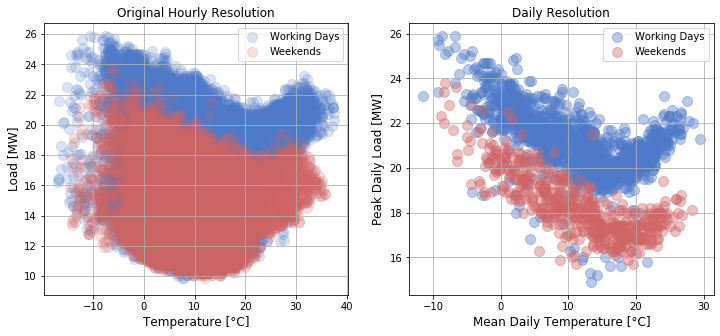

In [9]:
s = 100

fig = plt.figure(figsize=[12, 5])

fig.add_subplot(1, 2, 1)
plt.scatter(x=temp[ts.index.dayofweek < 5], 
            y=ts[ts.index.dayofweek < 5], alpha=0.2, s=s, color=blue);
plt.scatter(x=temp[ts.index.dayofweek >= 5], 
            y=ts[ts.index.dayofweek >= 5], alpha=0.2, s=s, color=red);
plt.grid()
plt.xlabel("Temperature [°C]", fontsize=12), 
plt.ylabel("Load [MW]", fontsize=12);
plt.legend(["Working Days", "Weekends"])
plt.title("Original Hourly Resolution");

fig.add_subplot(1, 2, 2)
plt.scatter(x=temp[ts.index.dayofweek < 5].resample("d").mean(), 
            y=ts[ts.index.dayofweek < 5].resample("d").max(), alpha=0.4, s=s, color=blue);

plt.scatter(x=temp[ts.index.dayofweek >= 5].resample("d").mean(), 
            y=ts[ts.index.dayofweek >= 5].resample("d").max(), alpha=0.4, s=s, color=red);
plt.grid()
plt.xlabel("Mean Daily Temperature [°C]", fontsize=12), 
plt.ylabel("Peak Daily Load [MW]", fontsize=12);
plt.legend(["Working Days", "Weekends"]);
plt.title("Daily Resolution");

## 4.3 Daily Load & Temperature Correlation - divided by season and day type

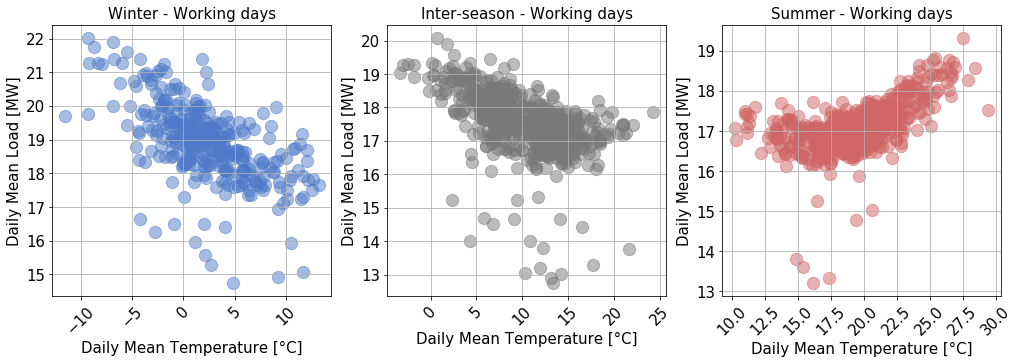

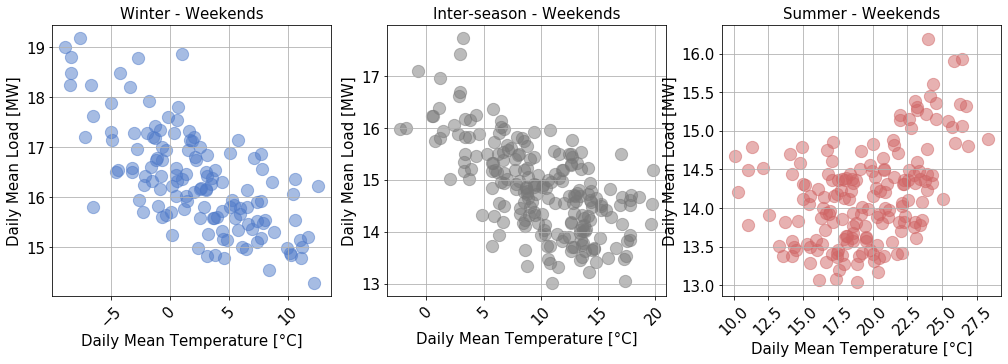

In [10]:
plot_scatter(x=temp.loc[ts.index.dayofweek < 5], 
             y=ts.loc[ts.index.dayofweek < 5], 
             xlabel="Daily Mean Temperature [°C]", 
             ylabel="Daily Mean Load [MW]", 
             title="Working days",
             freq="24h",
             s=150
             )

plot_scatter(x=temp.loc[ts.index.dayofweek >= 5], 
             y=ts.loc[ts.index.dayofweek >= 5], 
             xlabel="Daily Mean Temperature [°C]", 
             ylabel="Daily Mean Load [MW]", 
             title="Weekends",
             freq="24h",
             s=150
             )

## 4.4 Hourly Load & Temperature Correlation - divided by season, day type and hour

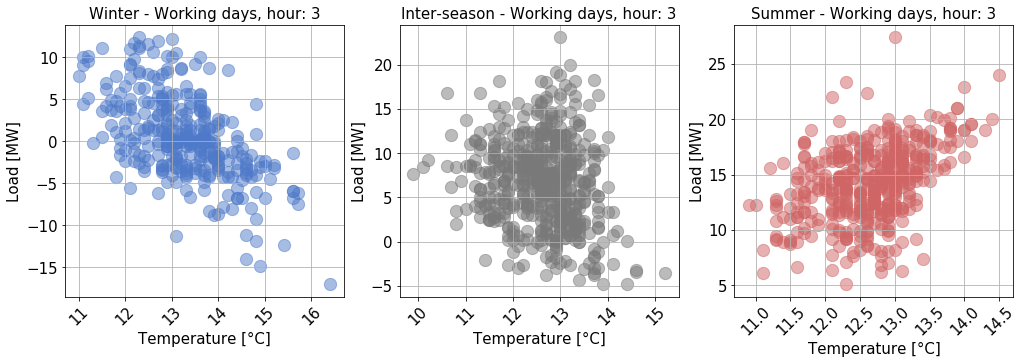

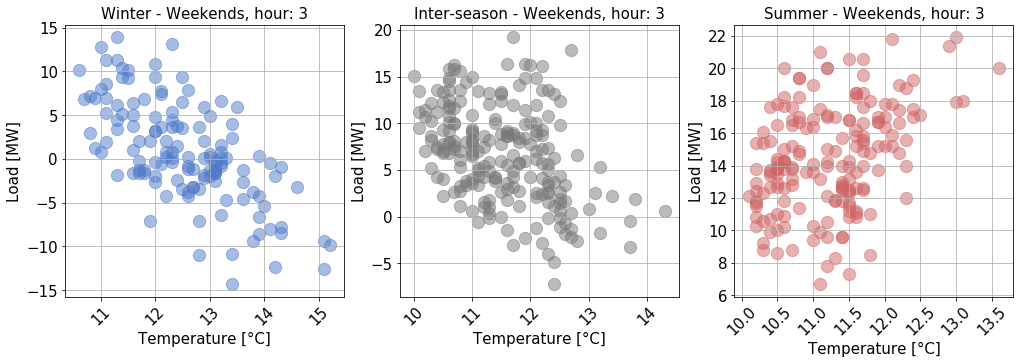

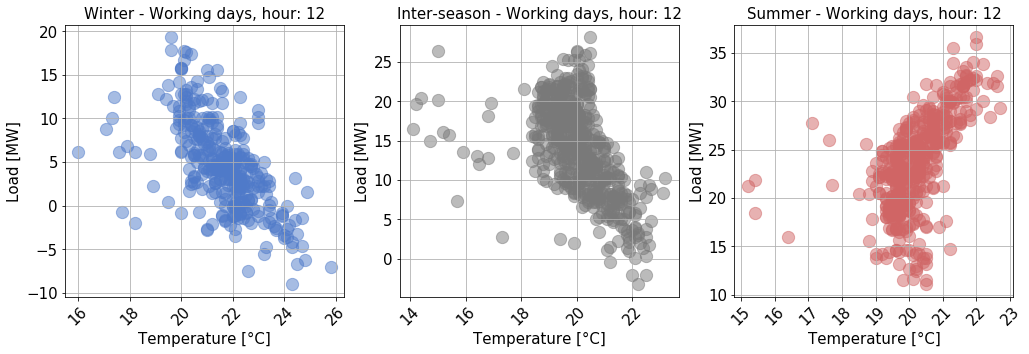

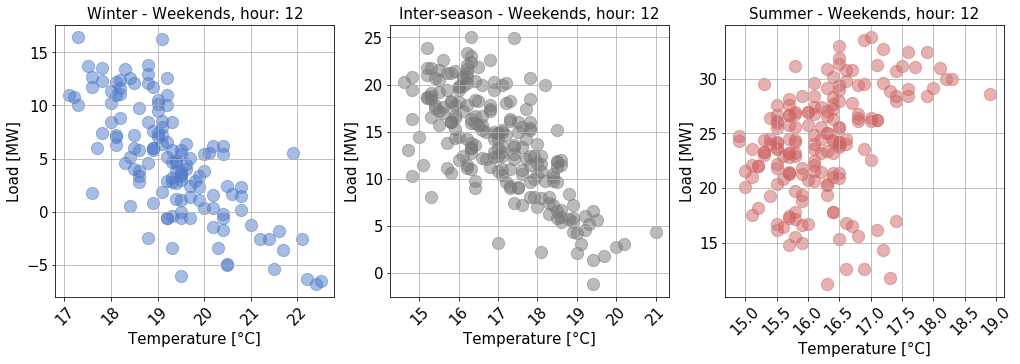

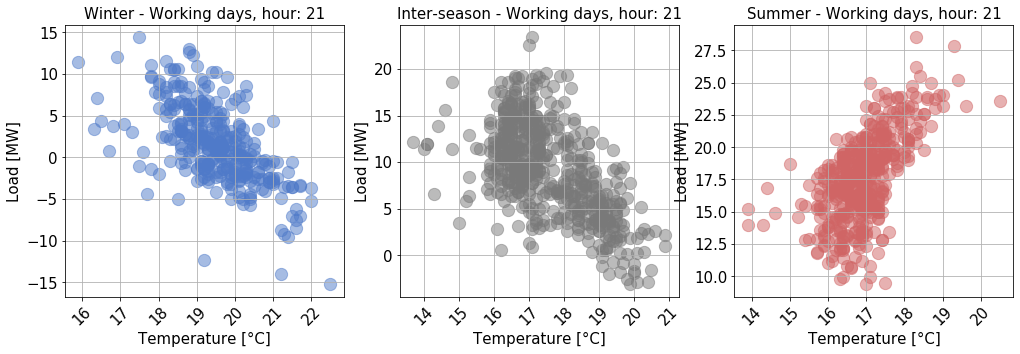

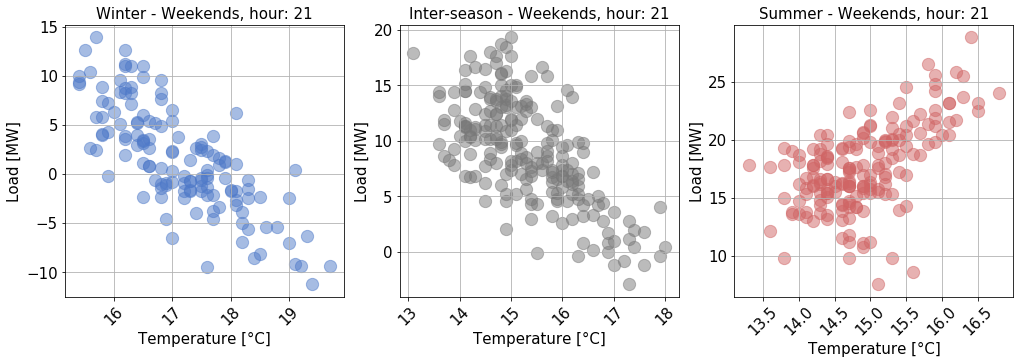

In [11]:
for hour in [3, 12, 21]:
    
    plot_scatter(x=ts.loc[(ts.index.dayofweek < 5) & (ts.index.hour == hour)], 
                 y=temp.loc[(ts.index.dayofweek < 5) & (ts.index.hour == hour)], 
                 xlabel="Temperature [°C]", 
                 ylabel="Load [MW]", 
                 title="Working days, hour: {}".format(hour),
                 freq="1h",
                 s=150)

    plot_scatter(x=ts.loc[(ts.index.dayofweek >= 5) & (ts.index.hour == hour)], 
                 y=temp.loc[(ts.index.dayofweek >= 5) & (ts.index.hour == hour)], 
                 xlabel="Temperature [°C]", 
                 ylabel="Load [MW]", 
                 title="Weekends, hour: {}".format(hour),  
                 freq="1h",
                 s=150)